1. Import all the necessary libraries.
2. Load the dataset.
3. Preprocess the data.
4. Determine the number of Gaussian mixtures(n_components) to use by computing the BIC score.
5. Fit the model
6. Detect the anomaly by using some anomaly metric.
    For example: If the non-anomalous data is Gaussian with some mean and variance, the points that receive low probability assignments under the chosen prior may be flagged as anomalous. 

** STEP 1 **

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn import mixture

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [2]:
import itertools
from scipy import linalg
import matplotlib as mpl

**STEP 2**

csv = pd.read_csv('data/Torschlag_Trafo_07122015_to_11122015.csv', sep=',')
train, test = sklearn.model_selection.train_test_split(csv, train_size = 0.8)

train.to_csv('data/Train_data_07_11_2015.csv',sep=',')

test.to_csv('data/Test_data_07_11_2015.csv',sep=',')

In [3]:
#df = pd.read_csv('Torschlag_Trafo_07122015_to_11122015.csv', sep=',')
train_data = pd.read_csv('data/Train_data_07_11_2015.csv', sep=',')
test_data = pd.read_csv('data/Test_data_07_11_2015.csv', sep=',')

In [4]:
train_data.head()

,Date,Time,V1,V2,V3,I1,I2,I3,I_N,Pges,Sges,CosPhi
0,2015-12-09,21:24:31,235.36,234.91,234.61,7.67,16.63,20.32,14.25,9772.93,10469.60,0.88
1,2015-12-10,23:36:33,237.36,237.05,236.52,7.29,16.73,17.95,16.81,9289.21,9941.19,0.88
2,2015-12-08,08:28:08,231.31,230.40,230.85,119.50,137.19,126.95,24.70,83781.78,88599.25,0.94
3,2015-12-11,13:13:42,231.79,231.11,231.05,66.04,81.74,79.52,21.21,50102.93,52555.68,0.95
4,2015-12-11,04:09:48,235.83,235.65,235.10,6.86,17.66,13.03,11.21,8521.57,8847.56,0.91


In [5]:
train_data = train_data[["V1","V2","V3","I1","I2","I3","Pges","Sges","CosPhi"]]
test_data = test_data[["V1","V2","V3","I1","I2","I3","Pges","Sges","CosPhi"]]

**STEP 3**

In [6]:
Std_train_data = StandardScaler().fit_transform(train_data)
Std_test_data = StandardScaler().fit_transform(test_data)

In [7]:
Std_train_data[:5]

array([[ 0.61186196,  0.60716179,  0.51914337, -0.7810617 , -0.95617834,
        -0.75743592, -0.85864056, -0.85273286, -0.65854118],
       [ 1.82712215,  1.81650902,  1.66725003, -0.79440919, -0.95329351,
        -0.83310191, -0.88237993, -0.87722806, -0.65854118],
       [-1.84903991, -1.94150923, -1.74100379,  3.14696253,  2.52176238,
         2.64689539,  2.77346844,  2.76907924,  1.01697849],
       [-1.55737747, -1.54027721, -1.6207832 ,  1.26918219,  0.9221289 ,
         1.13261767,  1.12062214,  1.09822781,  1.29623177],
       [ 0.8974481 ,  1.02534728,  0.81368382, -0.80951292, -0.92646467,
        -0.99018069, -0.92005316, -0.92792485,  0.17921865]])

**STEP 4**

A GaussianMixture.fit method is provided that learns a Gaussian Mixture Model from train data. Given test data, it can assign to each sample the Gaussian it mostly probably belong to using the GaussianMixture.predict method.

In [8]:
def compute_bic(X):
    cv_types = ['spherical', 'tied', 'diag', 'full']
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1,10)
    for cv_type in cv_types:
        for n in n_components_range:
            gmm = GaussianMixture(n_components = n, covariance_type='full')
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    bic = np.array(bic)
    return best_gmm, bic

In [9]:
def plot_bic(best_gmm, bic, X):
    cv_types = ['spherical', 'tied', 'diag', 'full']
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
    clf = best_gmm
    bars = []
    n_components_range = range(1,10)
    
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +.2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)
    
    # Plot the winner
    splot = plt.subplot(2, 1, 2)
    Y_ = clf.predict(X)
    for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,color_iter)):
        v, w = linalg.eigh(cov)
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
        
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(.5)
        splot.add_artist(ell)
    
    plt.xticks(())
    plt.yticks(())
    plt.title('Selected GMM: full model, 2 components')
    plt.subplots_adjust(hspace=.35, bottom=.02)
    plt.show()
    

In [10]:
best_gmm, bic = compute_bic(Std_train_data)


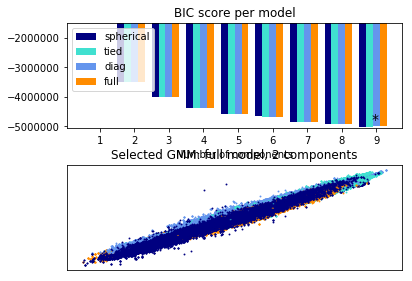

In [11]:
plot_bic(best_gmm, bic, Std_train_data)

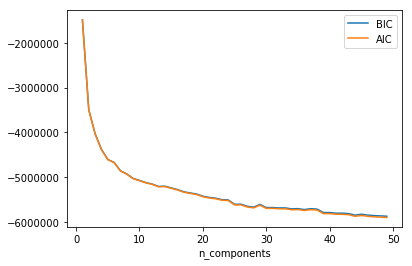

In [12]:
n_components = np.arange(1, 50)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Std_train_data)
          for n in n_components]

plt.plot(n_components, [m.bic(Std_train_data) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Std_train_data) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');



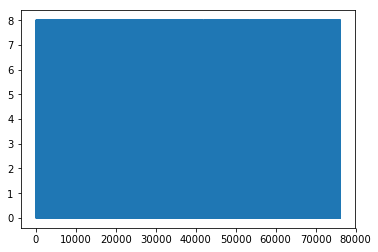

In [13]:
plt.plot(best_gmm.predict(Std_test_data))

**STEP 5**

In [14]:
def fit_data(data):
    gmix = mixture.GMM(n_components=2, covariance_type='full')
    gmix.fit(data)
    print gmix.means_
    colors = ['r' if i==0 else 'g' for i in gmix.predict(data)]
    ax = plt.gca()
    ax.scatter(data[:,0], data[:,1], c=colors, alpha=0.8)
    plt.show()

**STEP 6**